In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce

# Pre-processing the 10K and 1K datasets

In [4]:
ad_1k = sc.read_10x_h5("canada/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5")
ad_10k = sc.read_10x_h5("canada/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
ad_1k.var_names_make_unique()
ad_10k.var_names_make_unique()

In [6]:
print("1K:","%d x %d" % (ad_1k.n_vars, ad_1k.n_obs))
print("10K :","%d x %d" % (ad_10k.n_vars, ad_10k.n_obs))

1K: 33538 x 713
10K : 33538 x 7865


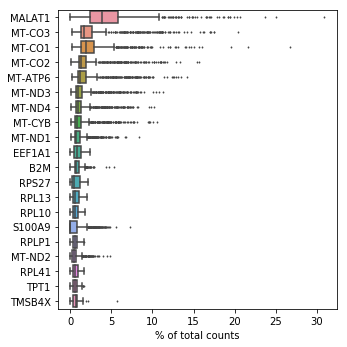

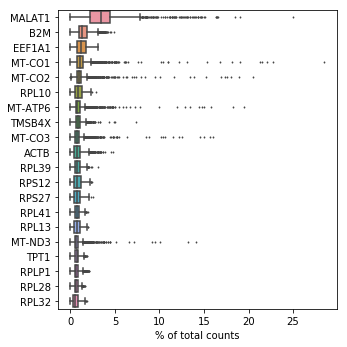

In [9]:
sc.pl.highest_expr_genes(ad_1k, n_top=20)
sc.pl.highest_expr_genes(ad_10k, n_top=20)

Similar highly variable set of genes

In [13]:
# bare minimum filtered -- populates *n_genes* slot
sc.pp.filter_cells(ad_10k, min_genes=200); sc.pp.filter_genes(ad_10k, min_cells=3)
sc.pp.filter_cells(ad_1k, min_genes=200); sc.pp.filter_genes(ad_1k, min_cells=3)

In [14]:
def calcMito(obj):
    mito_genes = obj.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    obj.obs['percent_mito'] = np.sum(obj[:, mito_genes].X, axis=1).A1 / np.sum(obj.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    obj.obs['n_counts'] = obj.X.sum(axis=1).A1

In [15]:
calcMito(ad_1k)
calcMito(ad_10k)

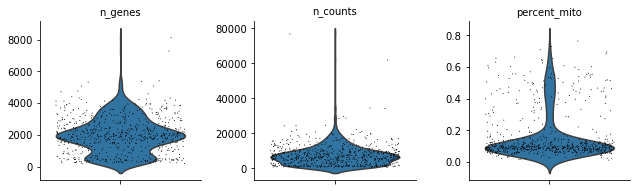

... storing 'feature_types' as categorical
... storing 'genome' as categorical


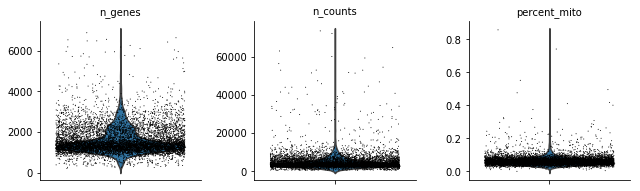

In [16]:
sc.pl.violin(ad_1k, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.violin(ad_10k, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)


MT is low, most counts < 20000, ngenes ~ 1500 in both sets

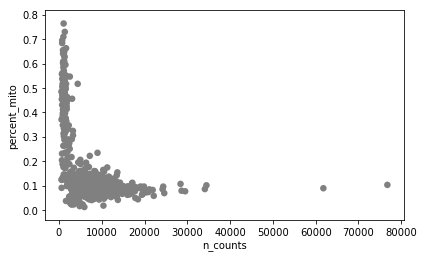

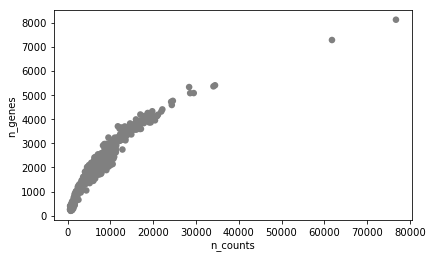

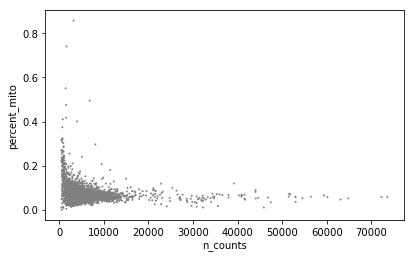

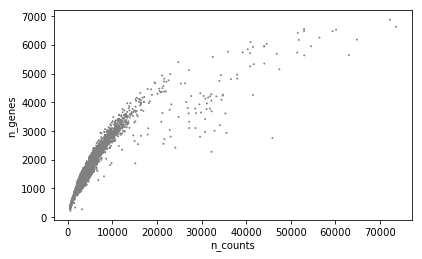

In [17]:
sc.pl.scatter(ad_1k, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_1k, x='n_counts', y='n_genes')
sc.pl.scatter(ad_10k, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_10k, x='n_counts', y='n_genes')

Let's remove MT% < 0.3 (wow that's high), and outlier n_counts > 25000, n_genes < 5000

In [22]:
ad_1k = ad_1k[ad_1k.obs['n_genes'] < 5000, :]
ad_1k = ad_1k[ad_1k.obs['percent_mito'] < 0.2, :]
ad_1k = ad_1k[ad_1k.obs['n_counts'] < 25000, :]
ad_1k = ad_1k[ad_1k.obs['n_counts'] > 500, :]

In [21]:
ad_10k = ad_10k[ad_10k.obs['n_genes'] < 5000, :]
ad_10k = ad_10k[ad_10k.obs['percent_mito'] < 0.2, :]
ad_10k = ad_10k[ad_10k.obs['n_counts'] < 25000, :]
ad_10k = ad_10k[ad_10k.obs['n_counts'] > 500, :]

Plot again the scatter plots and see if they are comparable

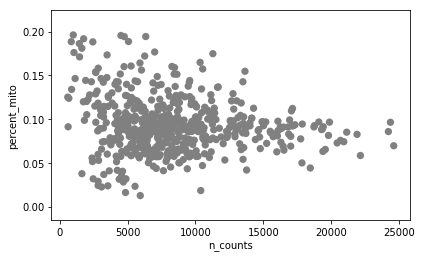

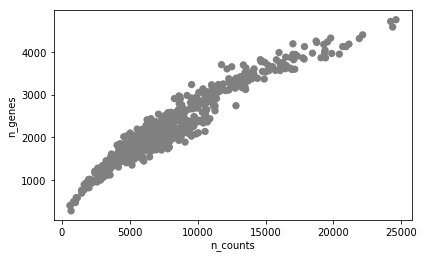

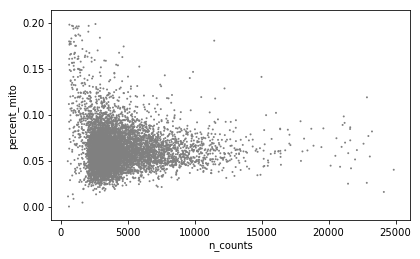

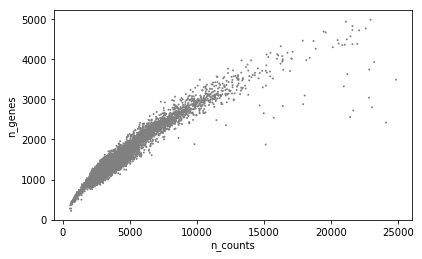

In [23]:
sc.pl.scatter(ad_1k, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_1k, x='n_counts', y='n_genes')
sc.pl.scatter(ad_10k, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_10k, x='n_counts', y='n_genes')

In [24]:
sc.pp.normalize_total(ad_1k)
sc.pp.normalize_total(ad_10k)

In [25]:
sc.pp.log1p(ad_1k)
sc.pp.log1p(ad_10k)

In [26]:
ad_1k.raw = ad_1k
ad_10k.raw = ad_10k

In [27]:
sc.pp.highly_variable_genes(ad_1k)
sc.pp.highly_variable_genes(ad_10k)

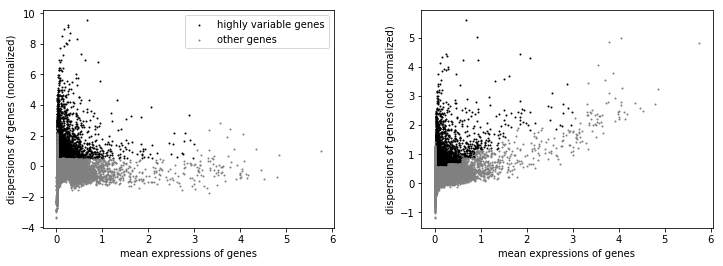

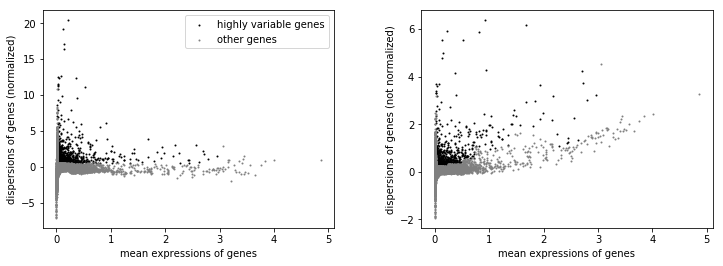

In [28]:
sc.pl.highly_variable_genes(ad_1k)
sc.pl.highly_variable_genes(ad_10k)

Filter for the highly variable genes

In [29]:
ad_1k = ad_1k[:, ad_1k.var['highly_variable']]
ad_10k = ad_10k[:, ad_10k.var['highly_variable']]

In [30]:
sc.pp.regress_out(ad_1k, ['n_counts', 'percent_mito'])
sc.pp.regress_out(ad_10k, ['n_counts', 'percent_mito'])

In [31]:
sc.pp.scale(ad_1k)
sc.pp.scale(ad_10k)

Perform the clustering over the neighbourhood graph. Assume PCs 1-40 relevant.

In [33]:
sc.tl.pca(ad_1k, svd_solver='arpack')
sc.tl.pca(ad_10k, svd_solver='arpack')

In [34]:
sc.pp.neighbors(ad_1k, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(ad_10k, n_neighbors=10, n_pcs=40)

In [35]:
sc.tl.umap(ad_1k)
sc.tl.umap(ad_10k)

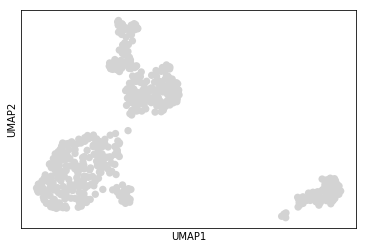

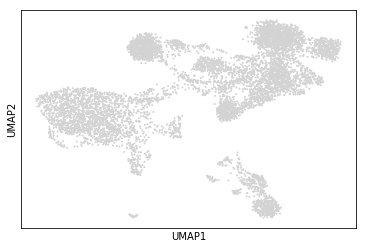

In [36]:
sc.pl.umap(ad_1k)
sc.pl.umap(ad_10k)

We see a lot of similarity. Let's cluster these and see if we can integrate the sets.

In [37]:
sc.tl.louvain(ad_1k)
sc.tl.louvain(ad_10k)

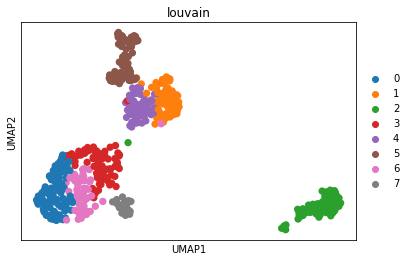

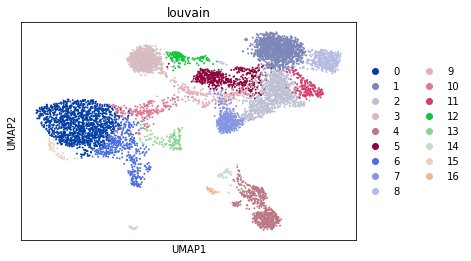

In [38]:
sc.pl.umap(ad_1k, color = 'louvain')
sc.pl.umap(ad_10k, color = 'louvain')

Write these to file and attempt to 

In [39]:
ad_1k.write("checkpoints/canada_1k.h5ad")
ad_10k.write("checkpoints/canada_10k.h5ad")

## Test MNN_Correct

In [40]:
# Label our batches
ad_1k.obs["Batch"] = 1
ad_10k.obs["Batch"] = 2

In [48]:
# Requires a COMMON set of highly variable genes, so we need to do an intersection
gene_intersect = ad_1k.var.index.intersection(ad_10k.var.index)

In [50]:
print("1K hvg=", len(ad_1k.var.index))
print("10K hvg=", len(ad_10k.var.index))
print("1k ^ 10k hvg=", len(gene_intersect))


1K hvg= 2629
10K hvg= 1345
1k ^ 10k hvg= 748


Use these 748 for the mnn correction. Feeding them in as the `var_subset` argument gives "lengths do not match" errors, so we need to actually subset the datasets with this intersection.

In [55]:
ad_1k_sub = ad_1k[:, gene_intersect]
ad_10k_sub = ad_10k[:, gene_intersect]

In [56]:
dat = sce.pp.mnn_correct(ad_1k_sub, ad_10k_sub, batch_key = "Batch", var_subset=gene_intersect)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [58]:
ad_mnn = dat[0]

In [72]:
print(
ad_mnn.obs.head(), '\n',
ad_mnn.obs.tail())

                     Batch louvain  n_counts  n_genes  percent_mito
AAACCCAAGTGGTCAG-1-0     0       2    4927.0     1505      0.139842
AAAGGTATCAACTACG-1-0     0       4    4812.0     1455      0.098296
AAAGTCCAGCGTGTCC-1-0     0       4    4760.0     1406      0.194328
AACACACTCAAGAGTA-1-0     0       2    4972.0     1537      0.090708
AACACACTCGACGAGA-1-0     0       6    4562.0     2017      0.035730 
                      Batch louvain  n_counts  n_genes  percent_mito
TTTGTTGGTTCAAGTC-1-1     1      14    5830.0     2178      0.055403
TTTGTTGGTTGCATGT-1-1     1       8    4096.0     1256      0.062500
TTTGTTGGTTGCGGCT-1-1     1       0    5524.0     1907      0.103910
TTTGTTGTCGAGTGAG-1-1     1       2    4039.0     1605      0.067096
TTTGTTGTCGTTCAGA-1-1     1       2    4212.0     1549      0.049620


We need to preserve the old louvain before we recompute the new one.

In [80]:
ad_mnn.obs["old_louvain"] = ad_mnn.obs[["Batch","louvain"]].apply(lambda x: "%03d" % ((100 * int(x[0])) + int(x[1])), axis=1)

In [81]:
print(
ad_mnn.obs.head(), '\n',
ad_mnn.obs.tail())

                     Batch louvain  n_counts  n_genes  percent_mito  \
AAACCCAAGTGGTCAG-1-0     0       2    4927.0     1505      0.139842   
AAAGGTATCAACTACG-1-0     0       4    4812.0     1455      0.098296   
AAAGTCCAGCGTGTCC-1-0     0       4    4760.0     1406      0.194328   
AACACACTCAAGAGTA-1-0     0       2    4972.0     1537      0.090708   
AACACACTCGACGAGA-1-0     0       6    4562.0     2017      0.035730   

                     old_louvain  
AAACCCAAGTGGTCAG-1-0         002  
AAAGGTATCAACTACG-1-0         004  
AAAGTCCAGCGTGTCC-1-0         004  
AACACACTCAAGAGTA-1-0         002  
AACACACTCGACGAGA-1-0         006   
                      Batch louvain  n_counts  n_genes  percent_mito  \
TTTGTTGGTTCAAGTC-1-1     1      14    5830.0     2178      0.055403   
TTTGTTGGTTGCATGT-1-1     1       8    4096.0     1256      0.062500   
TTTGTTGGTTGCGGCT-1-1     1       0    5524.0     1907      0.103910   
TTTGTTGTCGAGTGAG-1-1     1       2    4039.0     1605      0.067096   
TTTGTT

Now let's recluster and plot

In [83]:
sc.tl.pca(ad_mnn, svd_solver='arpack')
sc.pp.neighbors(ad_mnn, n_neighbors=10, n_pcs=40)
sc.tl.louvain(ad_mnn)

In [85]:
sc.tl.umap(ad_mnn)

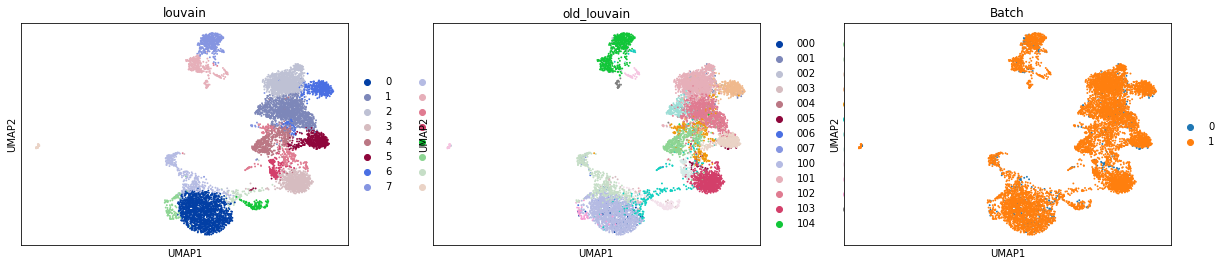

In [87]:
# Plot everything together
sc.pl.umap(ad_mnn, color=["louvain","old_louvain", "Batch"])

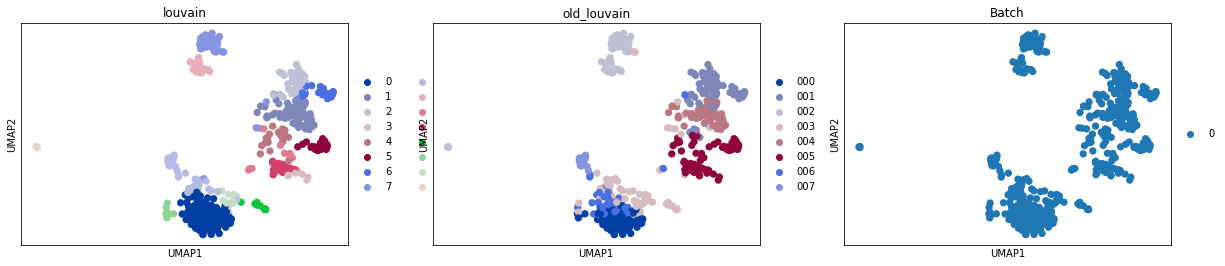

In [93]:
# Plot just the 1K batch using the new projection
sc.pl.umap(ad_mnn[ad_mnn.obs["Batch"].astype("int32")==0], color=["louvain","old_louvain", "Batch"])

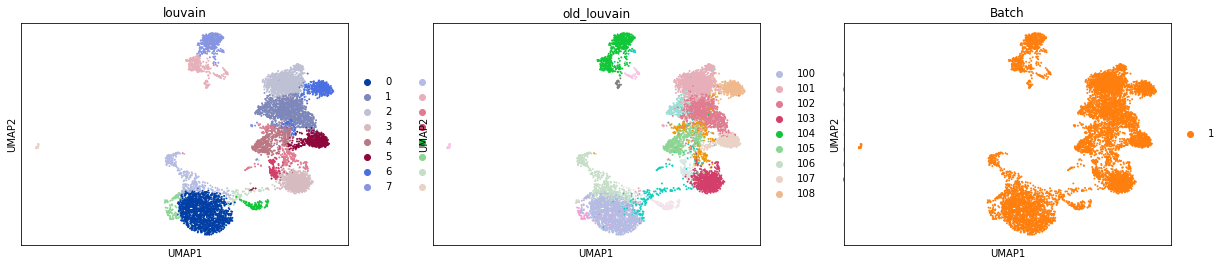

In [94]:
# Plot just the 10K batch using the new projection
sc.pl.umap(ad_mnn[ad_mnn.obs["Batch"].astype("int32")==1], color=["louvain","old_louvain", "Batch"])

In [95]:
ad_mnn.write("checkpoints/canada_mnn.h5ad")

29MB file, too big....

# Subsetting the Data for use in Galaxy

Ideally we just want only a few clusters. So we should select a few small clusters, extract their cells from the original matrices and try to *recluster* with the hope of still getting a good overlap.

In [104]:
# Let's pick 100 + 000, 104 + 002, 102 + 004
ad_mnn_sub = ad_mnn[ad_mnn.obs["old_louvain"].astype("str").isin(["000","002","004","100","102","104"])]

In [108]:
print(len(ad_mnn.obs),len(ad_mnn_sub.obs))

8284 3158


Halved our data practically

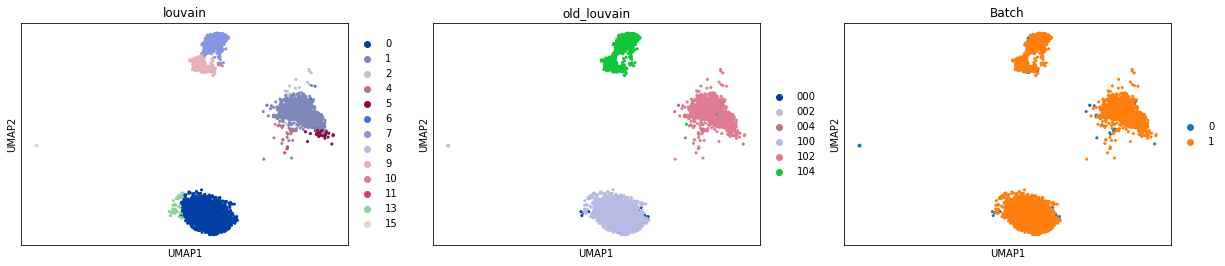

In [109]:
sc.pl.umap(ad_mnn_sub, color=["louvain","old_louvain", "Batch"])

Good overlapping clusters

In [110]:
ad_mnn_sub.write("checkpoints/canada_mnn_sub.h5ad")

11MB, still too big...